### Creating a  voxel-based 3d reconstruction from images

In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
from plyfile import PlyData

In [2]:
# Loading Data
cam_list=[
    [776.649963, -298.408539, -32.048386,  993.1581875, 132.852554,  120.885834,  -759.210876, 1982.174000, 0.744869,  0.662592,  -0.078377, 4.629312012],
    [431.503540,  586.251892,  -137.094040, 1982.053375, 23.799522,   1.964373,    -657.832764, 1725.253500, -0.321776, 0.869462,  -0.374826, 5.538025391],
    [-153.607925, 722.067139,  -127.204468, 2182.4950,   141.564346,  74.195686,   -637.070984, 1551.185125, -0.769772, 0.354474,  -0.530847, 4.737782227],
    [-823.909119, 55.557896,   -82.577644,  2498.20825,  -31.429972,  42.725830,   -777.534546, 2083.363250, -0.484634, -0.807611, -0.335998, 4.934550781],
    [-715.434998, -351.073730, -147.460815, 1978.534875, 29.429260,   -2.156084,   -779.121704, 2028.892750, 0.030776,  -0.941587, -0.335361, 4.141203125],
    [-417.221649, -700.318726, -27.361042,  1599.565000, 111.925537,  -169.101776, -752.020142, 1982.983750, 0.542421,  -0.837170, -0.070180, 3.929336426],
    [94.934860,   -668.213623, -331.895508, 769.8633125, -549.403137, -58.174614,  -342.555359, 1286.971000, 0.196630,  -0.136065, -0.970991, 3.574729736],
    [452.159027,  -658.943909, -279.703522, 883.495000,  -262.442566, 1.231108,    -751.532349, 1884.149625, 0.776201,  0.215114,  -0.592653, 4.235517090]]
#Reshaping camera matricies
cam_matrices=[np.array(c).reshape(3,4) for c in cam_list]
#Load
images = [cv2.cvtColor(cv2.imread(f'/Users/davidlaziuk/Desktop/cam0{i}_00023_0000008550.png'),cv2.COLOR_BGR2RGB) for i in range(8)]
silhouettes = [cv2.imread(f'/Users/davidlaziuk/Desktop/silh_cam0{i}_00023_0000008550.pbm',cv2.IMREAD_GRAYSCALE) for i in range(8)]

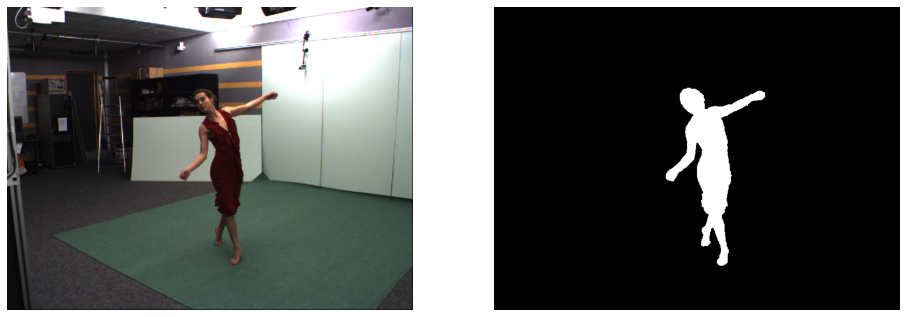

In [3]:
#Showing Sample of one image & Silhouette
fig=plt.figure(figsize=(16,8))
ax1=fig.add_subplot(1,2,1)
ax1.imshow(images[0])
ax1.axis('off')
ax2=fig.add_subplot(1,2,2)
ax2.imshow(silhouettes[0],cmap='gray')
ax2.axis('off')
plt.show()

In [4]:
# Step 1: Defining Voxel Grid
#Defining x,y,z range, and voxel size
XR,YR,ZR,VS=(-2.5,2.5),(-3,3),(0,2.5),0.005
#Finding voxel count in each dim.
xC,yC,zC=int((XR[1]-XR[0])/VS),int((YR[1]-YR[0])/VS),int((ZR[1]-ZR[0])/VS)
#Defining grid
vg=np.zeros((xC,yC,zC),dtype=np.uint8)

In [5]:
# Step 2: Determine Voxels forming the visual hull
#Iterate through all voxels
for i in range(xC):
    for j in range(yC):
        for k in range(zC):
            #Finding the center of each voxel
            xCen,yCen,zCen=XR[0]+i*VS,YR[0]+j*VS,ZR[0]+k*VS
            vc=np.array([xCen,yCen,zCen,1])
            #Projecting center to all images
            occ=True
            for cm,s in zip(cam_matrices,silhouettes):
                pp=cm@vc
                pp/=pp[2]
                x,y=int(pp[0]),int(pp[1])
                #Testing if in-bounds and in silhouette
                if(0<=x<780 and 0<=y<582):
                    if not(s[y,x]==255):
                        occ=False
                        break
            #If in set voxel to occupied
            if occ:
                vg[i,j,k]=1
tot_v=xC*yC*zC #Total number of voxels
occ_v=np.sum(vg==1) #Number occupied
rel_occ=occ_v/tot_v
print(f"Total voxels: {tot_v}")
print(f"Occupied voxels: {occ_v}")
print(f"Relative portion of occupied voxels: {rel_occ:.4f}")

Total voxels: 600000000
Occupied voxels: 787790
Relative portion of occupied voxels: 0.0013


In [6]:
#Step 3 Identify voxels that are in the reconstructed surface
def issv(i,j,k,vg):#Function to determine if voxel is on surface
    #All voxel neighbors
    nbs=[(i-1,j,k),(i+1,j,k),(i,j-1,k),(i,j+1,k),(i,j,k-1),(i,j,k+1)]
    #Test all neighbors
    for ni,nj,nk in nbs:
        if (vg[ni,nj,nk]==0):
            return True
    return False
sv=0
svg=np.zeros((xC,yC,zC),dtype=np.uint8)
for i in range(xC):
    for j in range(yC):
        for k in range(zC):
            #if surface voxel
            if vg[i,j,k]==1:
                if issv(i,j,k,vg):
                    #Add to count and populate new voxel grid
                    sv+=1
                    svg[i,j,k]=1
rel_sv=sv/tot_v
print(f"Surface voxels: {sv}")
print(f"Relative portion of surface voxels: {rel_sv:.4f}")

Surface voxels: 74726
Relative portion of surface voxels: 0.0001


In [7]:
# Step 4: Write an output PLY point cloud
#All faces
fs=[(-1,0,0),(1,0,0),(0,-1,0),(0,1,0),(0,0,-1),(0,0,1)]
vs=[]
n=0
for i in range(xC):
    for j in range(yC):
        for k in range(zC):
            if svg[i,j,k]==1:
                #Add center of all faces
                for fx,fy,fz in fs:
                    x,y,z=(i+0.5*fx)*VS,(j+0.5*fy)*VS,(k+0.5*fz)*VS
                    vs.append((x,y,z,255,255,255))
                    n+=1
#Write file              
with open('Laziuk_step4.ply','w') as f:
    f.write('ply\n')
    f.write('format ascii 1.0\n')
    f.write(f'element vertex {n}\n')
    f.write('property float x\n')
    f.write('property float y\n')
    f.write('property float z\n')
    f.write('property uchar red\n')
    f.write('property uchar green\n')
    f.write('property uchar blue\n')
    f.write('element face 0\n')
    f.write('end_header\n')
    for v in vs:
        f.write(f'{v[0]} {v[1]} {v[2]} {v[3]} {v[4]} {v[5]}\n')
print(f'Generated PLY file with {n} vertices.')

Generated PLY file with 448356 vertices.


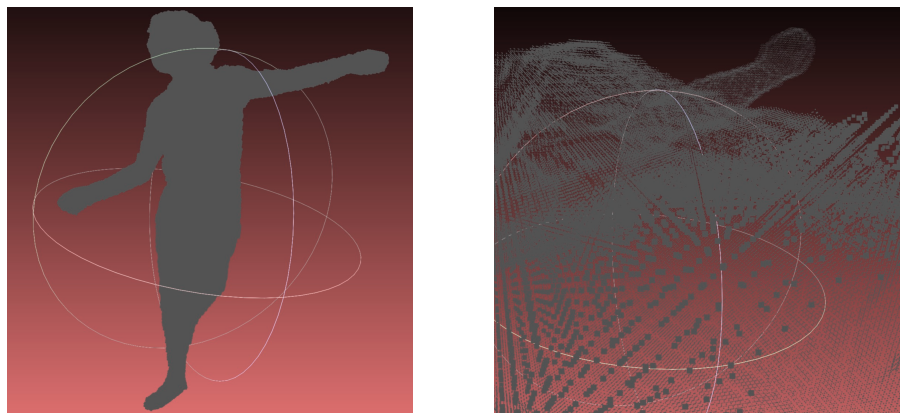

In [4]:
#Showing images of 3d model
ply1=cv2.imread('/Users/davidlaziuk/Desktop/VoxelGrid/1.jpg')
ply2=cv2.imread('/Users/davidlaziuk/Desktop/VoxelGrid/2.jpg')
fig=plt.figure(figsize=(16,8))
ax1=fig.add_subplot(1,2,1)
ax1.imshow(ply1)
ax1.axis('off')
ax2=fig.add_subplot(1,2,2)
ax2.imshow(ply2)
ax2.axis('off')
plt.show()

In [8]:
# Step 5: Textured PLY cloud
ps=[]
for i in range(xC):
    for j in range(yC):
        for k in range(zC):
            if(svg[i,j,k]==1):
                #Getting Center of Faces
                fcs=[]
                nbs=[(i-1,j,k),(i+1,j,k),(i,j-1,k),(i,j+1,k),(i,j,k-1),(i,j,k+1)]
                for ni, nj, nk in nbs:
                    try:
                        if (svg[ni,nj,nk]==0):
                                fcs.append((0.5*(i+ni),0.5*(j+nj),0.5*(k+nk)))
                    except IndexError: pass
                #Finding Voxel Color
                cs=[]
                for cm,img,s in zip(cam_matrices,images,silhouettes):
                    vis=False
                    pp=np.array([i*VS+XR[0],j*VS+YR[0],k*VS+ZR[0],1])
                    pp=np.dot(cm,pp)
                    pp=pp/pp[2]
                    x,y=int(pp[0]),int(pp[1])
                    if 0 <=x<img.shape[1] and 0<=y<img.shape[0] and s[y,x]:
                        vis=True
                    if vis:
                        cs.append(img[y,x])
                c=np.median(cs, axis=0) if cs else np.array([255,255,255])
                #Fixing Brightness by gamma correction
                c=np.power(c/255.0,1.0/2.2)*255
                ps.extend([(fc,c) for fc in fcs])
n=len(ps)
#Write file              
with open('Laziuk_step5.ply','w') as f:
    f.write('ply\n')
    f.write('format ascii 1.0\n')
    f.write(f'element vertex {n}\n')
    f.write('property float x\n')
    f.write('property float y\n')
    f.write('property float z\n')
    f.write('property uchar red\n')
    f.write('property uchar green\n')
    f.write('property uchar blue\n')
    f.write('element face 0\n')
    f.write('end_header\n')
    for p,c in ps:
        f.write(f'{p[0]} {p[1]} {p[2]} {round(c[0])} {round(c[1])} {round(c[2])}\n')
print(f'Generated PLY file with {n} vertices.')

Generated PLY file with 246712 vertices.


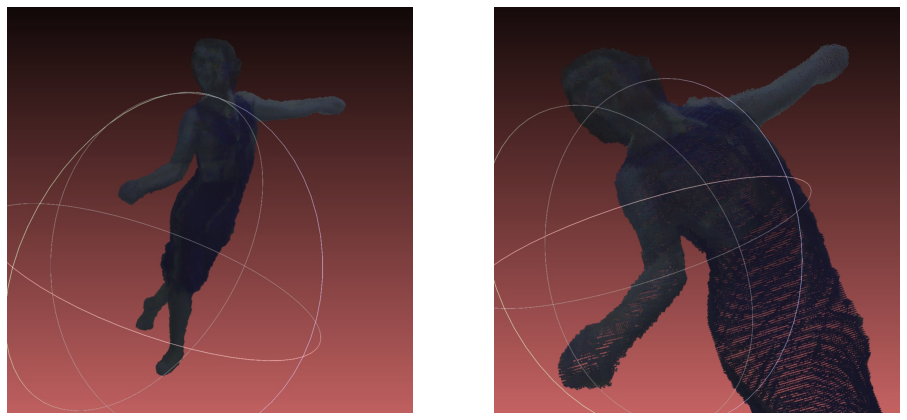

In [5]:
#Showing images of 3d model
ply3=cv2.imread('/Users/davidlaziuk/Desktop/VoxelGrid/3.jpg')
ply4=cv2.imread('/Users/davidlaziuk/Desktop/VoxelGrid/4.jpg')
fig=plt.figure(figsize=(16,8))
ax1=fig.add_subplot(1,2,1)
ax1.imshow(ply3)
ax1.axis('off')
ax2=fig.add_subplot(1,2,2)
ax2.imshow(ply4)
ax2.axis('off')
plt.show()